In [6]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as p

In [7]:
# Function to read the csv files from a filepath   

file_dict={ "delivery": "Deliveries.csv", "location":"Location.csv", "orders":"Orders_Sample.csv"}
       
def read_files(filepath):
    filepath=Path(filepath)
    dfs={}
    for label, filename in file_dict.items():
        dfs[label]=pd.read_csv(filepath/filename)
    return dfs

path="data"
df=read_files(path)
    
# Assigning direct variable for ease of use further. Instead of writing df["delivery"] we will directly call delivery.

delivery, location, orders = (df[i] for i in ["delivery", "location", "orders"])

In [8]:
delivery.head()

,delivery_id,order_id,trip_date,leg_direction,origin,destination,distance_miles,cancelled_leg,pickup_delay_min,dropoff_delay_min,on_time_outbound
0,D00000001,O0000001,2025-01-19,OUTBOUND,FC08,Z25,33.18,0,0.0,20.1,0.0
1,D00000002,O0000001,2025-01-19,RETURN,Z25,FC08,38.62,0,8.4,0.1,NaN
2,D00000003,O0000002,2025-03-03,OUTBOUND,FC04,Z03,62.98,0,14.0,17.1,0.0
3,D00000004,O0000002,2025-03-03,RETURN,Z03,FC04,63.14,0,3.2,0.0,NaN
4,D00000005,O0000003,2025-01-29,OUTBOUND,FC11,Z22,37.95,0,10.3,18.9,0.0


In [9]:
location.head()

,location_code,location_category,location_type,city,state
0,FC01,Fulfillment Center,medium,Denver,FL
1,FC02,Fulfillment Center,large,Minneapolis,AZ
2,FC03,Fulfillment Center,medium,Nashville,MI
3,FC04,Fulfillment Center,medium,Raleigh,GA
4,FC05,Fulfillment Center,large,Houston,NV


In [10]:
orders.head()

,order_id,order_date,fulfillment_center,delivery_zone,total_revenue_usd,van_capacity_units,used_capacity_units,utilization_rate,cancelled_round_trip
0,O0000001,2025-01-19,FC08,Z25,134.40,40,30,0.7500,0
1,O0000002,2025-03-03,FC04,Z03,199.41,70,51,0.7286,0
2,O0000003,2025-01-29,FC11,Z22,71.57,40,24,0.6000,0
3,O0000004,2025-03-07,FC10,Z24,160.45,50,44,0.8800,0
4,O0000005,2025-01-09,FC10,Z13,109.91,60,33,0.5500,0


In [11]:
# Data cleaning and transformation
def find_null_values(df):
    return df.isna().sum()

find_null_values(delivery)

delivery_id              0
order_id                 0
trip_date                0
leg_direction            0
origin                   0
destination              0
distance_miles           0
cancelled_leg            0
pickup_delay_min         0
dropoff_delay_min        0
on_time_outbound     60000
dtype: int64

In [12]:
find_null_values(location)

location_code        0
location_category    0
location_type        0
city                 0
state                0
dtype: int64

In [13]:
find_null_values(orders)

order_id                0
order_date              0
fulfillment_center      0
delivery_zone           0
total_revenue_usd       0
van_capacity_units      0
used_capacity_units     0
utilization_rate        0
cancelled_round_trip    0
dtype: int64

In [14]:
def to_integer_columns(df, cols):
    """
    Converts column to integer value in given dataframe
    Any non-convertible values like string or N/A converts to NaN
    Numeric values rounded to nearest whole number (3.6 to 4, 2.2 to 2)
    parameters: pandas dataframe and column name(s)
    returns: pandas dataframe with converted integer columns
    """
    df=df.copy()
    for c in cols:
        if c in df.columns:
            df[c]=pd.to_numeric(df[c], errors="coerce").round().astype("Int64")
    return df
    
delivery=to_integer_columns(delivery, ["on_time_outbound"])

In [15]:
# assigning the delivery loop to each flight. routes FC09 -> ZS5 and ZS5 -> FC09, will have same delivery loop FC09-ZS5

def assign_delivery_loop(df):
    df=df.copy()
    df["delivery_loop"]=np.where(df["origin"]<df["destination"], df["origin"]+"-"+df["destination"], df["destination"]+"-"+df["origin"])
    return df

delivery_routes=assign_delivery_loop(delivery)
delivery_routes.head()

,delivery_id,order_id,trip_date,leg_direction,origin,destination,distance_miles,cancelled_leg,pickup_delay_min,dropoff_delay_min,on_time_outbound,delivery_loop
0,D00000001,O0000001,2025-01-19,OUTBOUND,FC08,Z25,33.18,0,0.0,20.1,0,FC08-Z25
1,D00000002,O0000001,2025-01-19,RETURN,Z25,FC08,38.62,0,8.4,0.1,<NA>,FC08-Z25
2,D00000003,O0000002,2025-03-03,OUTBOUND,FC04,Z03,62.98,0,14.0,17.1,0,FC04-Z03
3,D00000004,O0000002,2025-03-03,RETURN,Z03,FC04,63.14,0,3.2,0.0,<NA>,FC04-Z03
4,D00000005,O0000003,2025-01-29,OUTBOUND,FC11,Z22,37.95,0,10.3,18.9,0,FC11-Z22


In [16]:
# calculating new column on_time_outbound_rate for each delivery loop as it will be needed later for score calculation

delivery_routes["on_time_outbound_rate"] = delivery_routes.groupby("delivery_loop")["on_time_outbound"].transform("mean")
delivery_routes.head()

,delivery_id,order_id,trip_date,leg_direction,origin,destination,distance_miles,cancelled_leg,pickup_delay_min,dropoff_delay_min,on_time_outbound,delivery_loop,on_time_outbound_rate
0,D00000001,O0000001,2025-01-19,OUTBOUND,FC08,Z25,33.18,0,0.0,20.1,0,FC08-Z25,0.378238
1,D00000002,O0000001,2025-01-19,RETURN,Z25,FC08,38.62,0,8.4,0.1,<NA>,FC08-Z25,0.378238
2,D00000003,O0000002,2025-03-03,OUTBOUND,FC04,Z03,62.98,0,14.0,17.1,0,FC04-Z03,0.336648
3,D00000004,O0000002,2025-03-03,RETURN,Z03,FC04,63.14,0,3.2,0.0,<NA>,FC04-Z03,0.336648
4,D00000005,O0000003,2025-01-29,OUTBOUND,FC11,Z22,37.95,0,10.3,18.9,0,FC11-Z22,0.333333


#### Q1. Find the Top 10 busiest delivery loops in 1Q2025 by number of completed round trips. Exclude cancelled round trips.

In [18]:
# We have only 1Q2025 data. My assumption of busiest delivery loops are the ones with the maximum number of trips in between the origin and destination
# Including only non-cancelled trips: We need to join the tables delivery and order to get only non-cancelled flights (order.cancelled_round_trip =0)

def join_tables(df1, df2, key, jtype):
    return df1.merge(df2, on=key, how=jtype)
    
delivery_orders = join_tables(delivery_routes, orders, "order_id", "left")


In [19]:
delivery_orders.head()

,delivery_id,order_id,trip_date,leg_direction,origin,destination,distance_miles,cancelled_leg,pickup_delay_min,dropoff_delay_min,...,delivery_loop,on_time_outbound_rate,order_date,fulfillment_center,delivery_zone,total_revenue_usd,van_capacity_units,used_capacity_units,utilization_rate,cancelled_round_trip
0,D00000001,O0000001,2025-01-19,OUTBOUND,FC08,Z25,33.18,0,0.0,20.1,...,FC08-Z25,0.378238,2025-01-19,FC08,Z25,134.40,40,30,0.7500,0
1,D00000002,O0000001,2025-01-19,RETURN,Z25,FC08,38.62,0,8.4,0.1,...,FC08-Z25,0.378238,2025-01-19,FC08,Z25,134.40,40,30,0.7500,0
2,D00000003,O0000002,2025-03-03,OUTBOUND,FC04,Z03,62.98,0,14.0,17.1,...,FC04-Z03,0.336648,2025-03-03,FC04,Z03,199.41,70,51,0.7286,0
3,D00000004,O0000002,2025-03-03,RETURN,Z03,FC04,63.14,0,3.2,0.0,...,FC04-Z03,0.336648,2025-03-03,FC04,Z03,199.41,70,51,0.7286,0
4,D00000005,O0000003,2025-01-29,OUTBOUND,FC11,Z22,37.95,0,10.3,18.9,...,FC11-Z22,0.333333,2025-01-29,FC11,Z22,71.57,40,24,0.6000,0


In [20]:
delivery_orders=delivery_orders[delivery_orders["cancelled_round_trip"]==0] # now we have removed the cancelled trips
data_per_loop= delivery_orders.groupby("delivery_loop", as_index=False).agg(number_of_trips=("delivery_id", "count")) # finding total count of trips in each loop
data_per_loop_sorted = data_per_loop.sort_values("number_of_trips", ascending=False).copy() # finding the top 10 loops with maximum number of trips
top10_busiest = data_per_loop_sorted.head(10)

#### Top 10 busiest delivery loops in 1Q2025 (excluding cancelled trips)

In [22]:
top10_busiest

,delivery_loop,number_of_trips
86,FC04-Z12,3056
287,FC12-Z13,2418
219,FC09-Z20,2096
77,FC04-Z03,1370
84,FC04-Z10,1166
267,FC11-Z18,1124
99,FC04-Z25,1116
87,FC04-Z13,1094
33,FC02-Z09,1066
82,FC04-Z08,1060


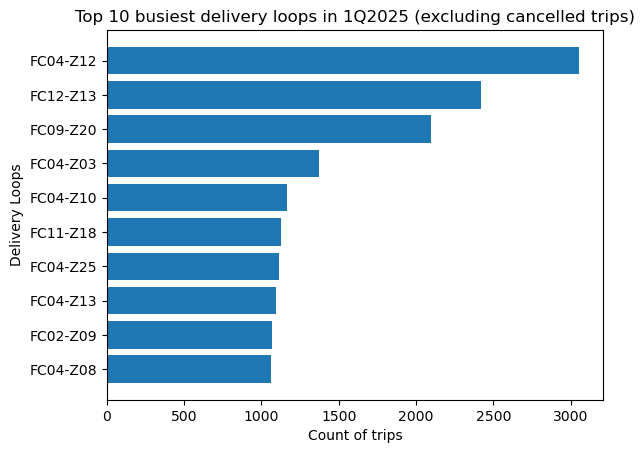

In [23]:
# Visualization of the Top 10 busiest delivery loops in 1Q2025 (excluding cancelled trips)

def plot_horizontal_barchart(df, x, y, title, xlabel, ylabel):
    p.barh(df[y], df[x])
    p.title(title)
    p.xlabel(xlabel)
    p.ylabel(ylabel)
    p.gca().invert_yaxis()
    p.show()
    
plot_horizontal_barchart(top10_busiest, "number_of_trips", "delivery_loop", "Top 10 busiest delivery loops in 1Q2025 (excluding cancelled trips)", "Count of trips", "Delivery Loops")


#### Q2. Compute the Top 10 most profitable loops in 1Q2025 excluding the upfront van cost.

In [25]:
delivery_orders.head()

,delivery_id,order_id,trip_date,leg_direction,origin,destination,distance_miles,cancelled_leg,pickup_delay_min,dropoff_delay_min,...,delivery_loop,on_time_outbound_rate,order_date,fulfillment_center,delivery_zone,total_revenue_usd,van_capacity_units,used_capacity_units,utilization_rate,cancelled_round_trip
0,D00000001,O0000001,2025-01-19,OUTBOUND,FC08,Z25,33.18,0,0.0,20.1,...,FC08-Z25,0.378238,2025-01-19,FC08,Z25,134.40,40,30,0.7500,0
1,D00000002,O0000001,2025-01-19,RETURN,Z25,FC08,38.62,0,8.4,0.1,...,FC08-Z25,0.378238,2025-01-19,FC08,Z25,134.40,40,30,0.7500,0
2,D00000003,O0000002,2025-03-03,OUTBOUND,FC04,Z03,62.98,0,14.0,17.1,...,FC04-Z03,0.336648,2025-03-03,FC04,Z03,199.41,70,51,0.7286,0
3,D00000004,O0000002,2025-03-03,RETURN,Z03,FC04,63.14,0,3.2,0.0,...,FC04-Z03,0.336648,2025-03-03,FC04,Z03,199.41,70,51,0.7286,0
4,D00000005,O0000003,2025-01-29,OUTBOUND,FC11,Z22,37.95,0,10.3,18.9,...,FC11-Z22,0.333333,2025-01-29,FC11,Z22,71.57,40,24,0.6000,0


In [26]:
# Merging the location dataset with the already joined delivery+orders dataset

# we first need to rename the location_code column of location dataset to fulfillment_center and then merge
location=location.rename(columns={"location_code":"delivery_zone"})
delivery_orders_location = join_tables(delivery_orders, location, "delivery_zone", "left")
delivery_orders_location.head()

,delivery_id,order_id,trip_date,leg_direction,origin,destination,distance_miles,cancelled_leg,pickup_delay_min,dropoff_delay_min,...,delivery_zone,total_revenue_usd,van_capacity_units,used_capacity_units,utilization_rate,cancelled_round_trip,location_category,location_type,city,state
0,D00000001,O0000001,2025-01-19,OUTBOUND,FC08,Z25,33.18,0,0.0,20.1,...,Z25,134.40,40,30,0.7500,0,Delivery Zone,large,Charlotte,TN
1,D00000002,O0000001,2025-01-19,RETURN,Z25,FC08,38.62,0,8.4,0.1,...,Z25,134.40,40,30,0.7500,0,Delivery Zone,large,Charlotte,TN
2,D00000003,O0000002,2025-03-03,OUTBOUND,FC04,Z03,62.98,0,14.0,17.1,...,Z03,199.41,70,51,0.7286,0,Delivery Zone,medium,San Diego,PA
3,D00000004,O0000002,2025-03-03,RETURN,Z03,FC04,63.14,0,3.2,0.0,...,Z03,199.41,70,51,0.7286,0,Delivery Zone,medium,San Diego,PA
4,D00000005,O0000003,2025-01-29,OUTBOUND,FC11,Z22,37.95,0,10.3,18.9,...,Z22,71.57,40,24,0.6000,0,Delivery Zone,medium,Phoenix,OR


In [27]:
# Filtering to only non-cancelled trips and medium and large fulfillment centres
final_data=delivery_orders_location[(delivery_orders_location["cancelled_round_trip"]==0) & ((delivery_orders_location["location_type"]=="medium") | (delivery_orders_location["location_type"]=="large"))]
final_data.head()

,delivery_id,order_id,trip_date,leg_direction,origin,destination,distance_miles,cancelled_leg,pickup_delay_min,dropoff_delay_min,...,delivery_zone,total_revenue_usd,van_capacity_units,used_capacity_units,utilization_rate,cancelled_round_trip,location_category,location_type,city,state
0,D00000001,O0000001,2025-01-19,OUTBOUND,FC08,Z25,33.18,0,0.0,20.1,...,Z25,134.40,40,30,0.7500,0,Delivery Zone,large,Charlotte,TN
1,D00000002,O0000001,2025-01-19,RETURN,Z25,FC08,38.62,0,8.4,0.1,...,Z25,134.40,40,30,0.7500,0,Delivery Zone,large,Charlotte,TN
2,D00000003,O0000002,2025-03-03,OUTBOUND,FC04,Z03,62.98,0,14.0,17.1,...,Z03,199.41,70,51,0.7286,0,Delivery Zone,medium,San Diego,PA
3,D00000004,O0000002,2025-03-03,RETURN,Z03,FC04,63.14,0,3.2,0.0,...,Z03,199.41,70,51,0.7286,0,Delivery Zone,medium,San Diego,PA
4,D00000005,O0000003,2025-01-29,OUTBOUND,FC11,Z22,37.95,0,10.3,18.9,...,Z22,71.57,40,24,0.6000,0,Delivery Zone,medium,Phoenix,OR


In [28]:
#Location handling fee is charged only at the Delivery Zone, No fee charged at Fulfillment Centers

final_data = final_data.copy()
final_data["delivery_loc_fee"]=np.where(final_data["location_category"]=="Delivery Zone", np.where(final_data["location_type"]=="large", 80, 50), 0)
final_data.head()

,delivery_id,order_id,trip_date,leg_direction,origin,destination,distance_miles,cancelled_leg,pickup_delay_min,dropoff_delay_min,...,total_revenue_usd,van_capacity_units,used_capacity_units,utilization_rate,cancelled_round_trip,location_category,location_type,city,state,delivery_loc_fee
0,D00000001,O0000001,2025-01-19,OUTBOUND,FC08,Z25,33.18,0,0.0,20.1,...,134.40,40,30,0.7500,0,Delivery Zone,large,Charlotte,TN,80
1,D00000002,O0000001,2025-01-19,RETURN,Z25,FC08,38.62,0,8.4,0.1,...,134.40,40,30,0.7500,0,Delivery Zone,large,Charlotte,TN,80
2,D00000003,O0000002,2025-03-03,OUTBOUND,FC04,Z03,62.98,0,14.0,17.1,...,199.41,70,51,0.7286,0,Delivery Zone,medium,San Diego,PA,50
3,D00000004,O0000002,2025-03-03,RETURN,Z03,FC04,63.14,0,3.2,0.0,...,199.41,70,51,0.7286,0,Delivery Zone,medium,San Diego,PA,50
4,D00000005,O0000003,2025-01-29,OUTBOUND,FC11,Z22,37.95,0,10.3,18.9,...,71.57,40,24,0.6000,0,Delivery Zone,medium,Phoenix,OR,50


In [29]:
# Grouping the final data by each delivery loop in the dataset

data_by_delivery_loop = final_data.groupby("delivery_loop", as_index=False).agg(distance=("distance_miles", "sum"), delivery_location_fee =("delivery_loc_fee", "sum"), total_delay_min= ("dropoff_delay_min", "sum"), total_revenue = ("total_revenue_usd", "sum"), avg_utilization_rate=("utilization_rate", "mean"), avg_on_time_delivery_rate=("on_time_outbound_rate", "mean")) 
data_by_delivery_loop.head()

,delivery_loop,distance,delivery_location_fee,total_delay_min,total_revenue,avg_utilization_rate,avg_on_time_delivery_rate
0,FC01-Z01,4633.54,10100,1380.2,26046.88,0.663793,0.284314
1,FC01-Z02,3845.22,8400,1027.7,20831.88,0.624408,0.298851
2,FC01-Z03,14605.59,23500,2880.6,73994.46,0.798725,0.432773
3,FC01-Z04,5109.93,16000,1250.1,27918.94,0.668622,0.330097
4,FC01-Z05,1801.29,4400,548.1,9971.98,0.590530,0.377778


In [30]:
# Total Cost calculation
def calculate_cost(df):
    df=df.copy()
    df["operating_cost"]=df["distance"]*1.2
    df["delay_cost"]=np.where(df["total_delay_min"]>10, df["total_delay_min"]*2, 0)
    df["total_cost"]=df["operating_cost"]+df["delivery_location_fee"]+df["delay_cost"]
    return df

# Total Profit Calculation
def calculate_profit(df):
    df=df.copy()
    df["total_profit"]=df["total_revenue"]-df["total_cost"]
    return df

data_by_delivery_loop=calculate_cost(data_by_delivery_loop)
data_by_delivery_loop=calculate_profit(data_by_delivery_loop)

#final_data_by_loop=final_data.groupby("delivery_loop", as_index=False).agg(total_profit=("t_profit", "sum"), avg_utilization_rate=("utilization_rate", "mean"), avg_on_time_delivery_rate=("on_time_outbound_rate", "mean"))
final_data_by_loop = data_by_delivery_loop.sort_values("total_profit", ascending = False)
final_data_by_loop.head()

,delivery_loop,distance,delivery_location_fee,total_delay_min,total_revenue,avg_utilization_rate,avg_on_time_delivery_rate,operating_cost,delay_cost,total_cost,total_profit
287,FC12-Z13,97349.20,120900,15752.4,373919.14,0.761634,0.344828,116819.040,31504.8,269223.840,104695.300
219,FC09-Z20,68384.34,104800,13026.5,305570.10,0.736297,0.341441,82061.208,26053.0,212914.208,92655.892
86,FC04-Z12,145653.66,152800,18998.8,447154.58,0.701898,0.332492,174784.392,37997.6,365581.992,81572.588
77,FC04-Z03,72279.62,68500,8259.7,230258.78,0.797440,0.336648,86735.544,16519.4,171754.944,58503.836
33,FC02-Z09,26479.37,53300,6444.4,143726.46,0.700498,0.339416,31775.244,12888.8,97964.044,45762.416


#### Top 10 most profitable loops in 1Q2025

In [32]:
top10_profitable = final_data_by_loop.head(10)
top10_profitable

,delivery_loop,distance,delivery_location_fee,total_delay_min,total_revenue,avg_utilization_rate,avg_on_time_delivery_rate,operating_cost,delay_cost,total_cost,total_profit
287,FC12-Z13,97349.20,120900,15752.4,373919.14,0.761634,0.344828,116819.040,31504.8,269223.840,104695.300
219,FC09-Z20,68384.34,104800,13026.5,305570.10,0.736297,0.341441,82061.208,26053.0,212914.208,92655.892
86,FC04-Z12,145653.66,152800,18998.8,447154.58,0.701898,0.332492,174784.392,37997.6,365581.992,81572.588
77,FC04-Z03,72279.62,68500,8259.7,230258.78,0.797440,0.336648,86735.544,16519.4,171754.944,58503.836
33,FC02-Z09,26479.37,53300,6444.4,143726.46,0.700498,0.339416,31775.244,12888.8,97964.044,45762.416
127,FC06-Z03,44049.80,49500,6260.7,159154.44,0.798252,0.342574,52859.760,12521.4,114881.160,44273.280
252,FC11-Z03,37281.52,45400,5500.1,145326.92,0.789222,0.367304,44737.824,11000.2,101138.024,44188.896
84,FC04-Z10,60041.87,58300,7111.9,187394.08,0.775898,0.348259,72050.244,14223.8,144574.044,42820.036
227,FC10-Z03,31774.99,39900,4941.0,129891.00,0.798917,0.389706,38129.988,9882.0,87911.988,41979.012
87,FC04-Z13,55655.50,54700,6991.3,175763.44,0.774289,0.328671,66786.600,13982.6,135469.200,40294.240


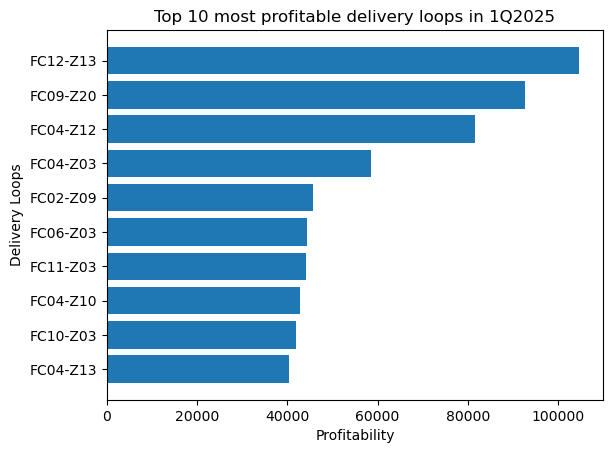

In [33]:
# Visualization of the most profitable loops in 1Q2025

plot_horizontal_barchart(top10_profitable, "total_profit", "delivery_loop", "Top 10 most profitable delivery loops in 1Q2025", "Profitability", "Delivery Loops")

#### Q3. Which 5 delivery loops should the company launch first and why?

Since the company’s motto is “Fast, fresh, reliable.” So, according to me, on-time performance and high utilization, along with profit, matter the most here. I will use these 3 factors to develop a scorecard to identify the top 5 delivery loops that will benefit the company if launched first. 
* Profit per round trip (higher is better) - 50%
* On-time rate (higher is better) procured from the column on_time_outbound from the Deliveries dataset - 30%
* Utilization rate (higher is better) procured from the Orders dataset - 20%

In [36]:
# Normalization to have the same scale for all 3 factors

def perform_normalization(df):
    df=df.copy()
    t_profit = df["total_profit"]
    on_time_rate = df["avg_on_time_delivery_rate"]
    utilization = df["avg_utilization_rate"]
    net_profit = (t_profit-t_profit.min())/(t_profit.max()-t_profit.min())
    df["profit_score"]= 1-net_profit
    df["punctuality_score"] = (on_time_rate-on_time_rate.min())/(on_time_rate.max()-on_time_rate.min())
    df["utilization_score"] = (utilization-utilization.min())/(utilization.max()-utilization.min())
    return df

normalized_data = perform_normalization(final_data_by_loop)    

In [37]:
# Score calculation

def calculate_top_score(df, profit_w, punctuality_w, utilization_w):
    df=df.copy()
    df["score"]= profit_w*df["profit_score"] + punctuality_w*df["punctuality_score"] + utilization_w*df["utilization_score"]
    df=df.sort_values("score", ascending=False).reset_index(drop=True)
    return df


score_report = calculate_top_score(normalized_data, 0.5, 0.3, 0.2)    

#### Top 5 delivery loops in 1Q2025

In [39]:
top5_delivery_loops = score_report.head(5)
top5_delivery_loops

,delivery_loop,distance,delivery_location_fee,total_delay_min,total_revenue,avg_utilization_rate,avg_on_time_delivery_rate,operating_cost,delay_cost,total_cost,total_profit,profit_score,punctuality_score,utilization_score,score
0,FC07-Z15,3371.24,6900,757.8,19560.92,0.748288,0.458333,4045.488,1515.6,12461.088,7099.832,0.893957,0.770833,0.731089,0.824446
1,FC07-Z18,1352.90,3800,410.3,9377.46,0.663271,0.5,1623.480,820.6,6244.080,3133.380,0.930289,0.886986,0.369551,0.80515
2,FC07-Z24,3892.01,13600,1081.1,24613.66,0.732204,0.425287,4670.412,2162.2,20432.612,4181.048,0.920692,0.678712,0.662688,0.796497
3,FC07-Z05,857.94,2100,209.8,4582.58,0.607324,0.52381,1029.528,419.6,3549.128,1033.452,0.949524,0.953359,0.131634,0.787097
4,FC05-Z10,7764.99,14200,1677.8,42058.22,0.767895,0.432432,9317.988,3355.6,26873.588,15184.632,0.819902,0.69863,0.814466,0.782433


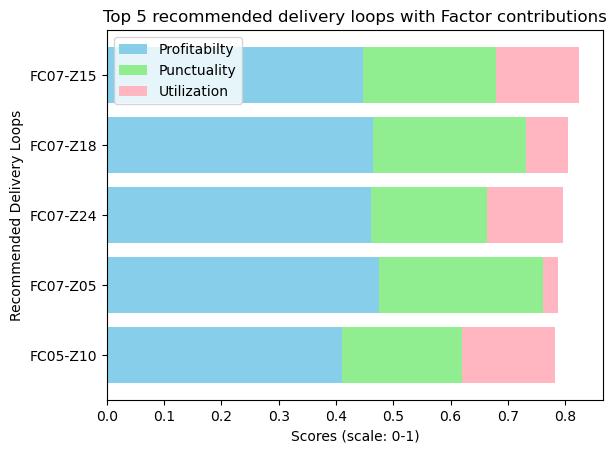

In [40]:
# Plotting horizontal weighted bar graph for the visualization of the top 5 delivery loops in 1Q2025

def plot_weighted_hbar(df, profit_w, punctuality_w, utilization_w):
    w1= profit_w*df["profit_score"] 
    w2= punctuality_w*df["punctuality_score"]
    w3= utilization_w*df["utilization_score"]
    loops=df["delivery_loop"]
    p.barh(loops, w1, label="Profitabilty", color = "skyblue")
    p.barh(loops, w2, left=w1, label="Punctuality",  color = "lightgreen")
    p.barh(loops, w3, left=w1+w2, label="Utilization",  color = "lightpink")
    p.gca().invert_yaxis()
    p.title("Top 5 recommended delivery loops with Factor contributions")
    p.xlabel("Scores (scale: 0-1)")
    p.ylabel("Recommended Delivery Loops")
    p.legend()
    p.show()  
    
plot_weighted_hbar(top5_delivery_loops, 0.5, 0.3, 0.2)

#### Q4. How many round trips are needed to break even on the $120,000 van investment?

In [42]:
def calculate_break_even(df, fixed_cost):
    df=df.copy()
    df["breakeven_exact_value"]= fixed_cost/df['total_profit']
    #as the number of round trips needs to be a whole number count
    df["breakeven_count"]=  np.ceil(df["breakeven_exact_value"]) 
    return df

break_even_details = calculate_break_even(top5_delivery_loops, 120000)
break_even_details = break_even_details.sort_values("breakeven_exact_value", ascending = False).reset_index(drop=True)
break_even_details[["delivery_loop", "score", "breakeven_exact_value", "breakeven_count"]]

,delivery_loop,score,breakeven_exact_value,breakeven_count
0,FC07-Z05,0.787097,116.115698,117.0
1,FC07-Z18,0.80515,38.297302,39.0
2,FC07-Z24,0.796497,28.700938,29.0
3,FC07-Z15,0.824446,16.901808,17.0
4,FC05-Z10,0.782433,7.902727,8.0


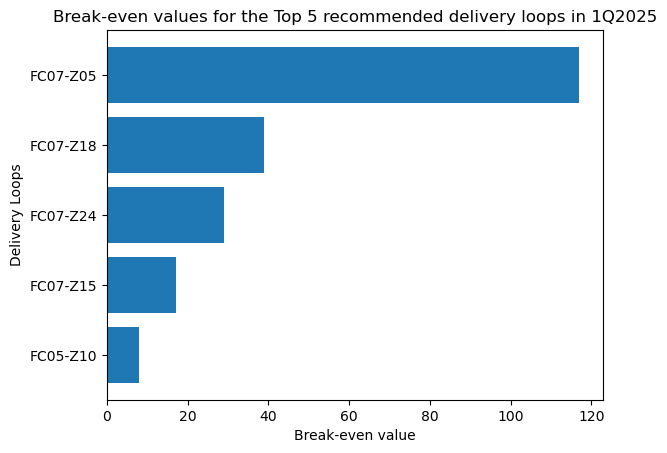

In [43]:
# Visualization of the break-even round trips for each of the top delivery loops in 1Q2025

plot_horizontal_barchart(break_even_details, "breakeven_count", "delivery_loop", "Break-even values for the Top 5 recommended delivery loops in 1Q2025", "Break-even value", "Delivery Loops")

So, my final recommendation is to invest in these routes as they are ranked the top in terms of punctuality, profitabilty and utilization rate. 
1. FC07-Z15
2. FC07-Z18
3. FC07-Z24
4. FC07-Z05
5. FC05-Z10

These routes are able to break even the upfront cost in a considerably lesser number of round trips with route FC05-Z10 being able to break-even the fastest.